In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline, make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.cluster.hierarchy import fcluster, dendrogram, linkage
from sklearn.cluster import DBSCAN
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('Mall_Customers.csv')

In [3]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### 1. Exploratory Data Analysis (EDA)

In [4]:
# There are no missing values in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [5]:
# CustomerID is not required for modeling
df = df.drop('CustomerID', axis=1)

In [6]:
df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


Female    0.56
Male      0.44
Name: Gender, dtype: float64


<AxesSubplot:xlabel='Gender', ylabel='count'>

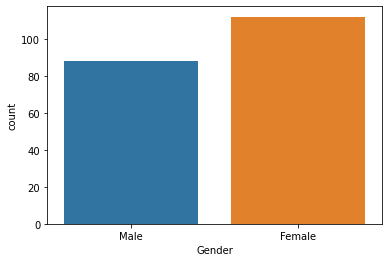

In [7]:
# data is unbaised - equally distributed between men & women
print (df['Gender'].value_counts() / len(df))
sns.countplot(x='Gender',data=df)

<AxesSubplot:xlabel='Age'>

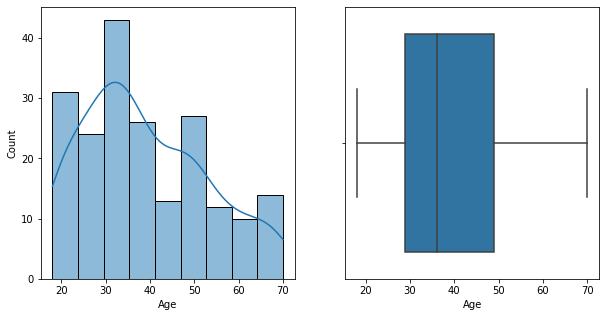

In [8]:
# average age of customers in the dataset is mid 30s
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.histplot(x='Age',data=df, kde=True, ax=axes[0])
sns.boxplot(x='Age',data=df, ax=axes[1])

Gender
Female    38.098214
Male      39.806818
Name: Age, dtype: float64


<AxesSubplot:xlabel='Gender', ylabel='Age'>

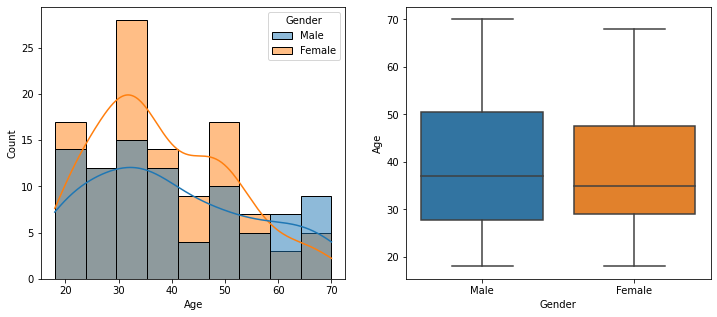

In [9]:
# average age of males is is slightly higher (older) than females 
print (df.groupby('Gender')['Age'].mean())
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.histplot(x='Age',data=df, kde=True, hue='Gender', ax=axes[0])
sns.boxplot(x='Gender',data=df, y='Age', ax=axes[1])

<AxesSubplot:xlabel='Annual Income (k$)'>

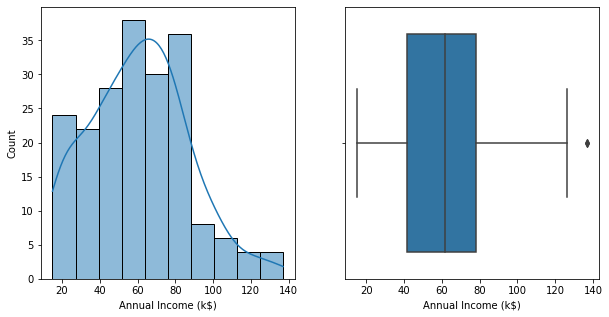

In [10]:
# average income of customers is 60k with few outliers 
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.histplot(x='Annual Income (k$)',data=df, kde=True, ax=axes[0])
sns.boxplot(x='Annual Income (k$)',data=df, ax=axes[1])

Gender
Female    59.250000
Male      62.227273
Name: Annual Income (k$), dtype: float64


<AxesSubplot:xlabel='Gender', ylabel='Annual Income (k$)'>

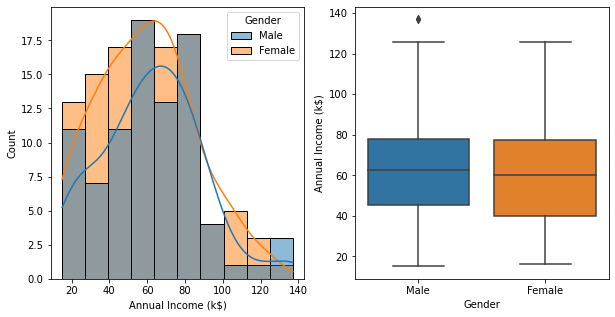

In [11]:
# Higher average annual income for males than females in the dataset
print (df.groupby('Gender')['Annual Income (k$)'].mean())
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.histplot(x='Annual Income (k$)',data=df, hue='Gender', kde=True, ax=axes[0])
sns.boxplot(y='Annual Income (k$)',data=df, x='Gender',ax=axes[1])

<AxesSubplot:xlabel='Spending Score (1-100)'>

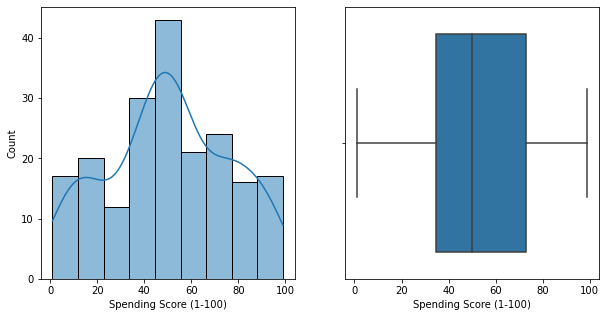

In [12]:
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.histplot(x='Spending Score (1-100)',data=df, kde=True, ax=axes[0])
sns.boxplot(x='Spending Score (1-100)',data=df, ax=axes[1])

Gender
Female    51.526786
Male      48.511364
Name: Spending Score (1-100), dtype: float64


<AxesSubplot:xlabel='Gender', ylabel='Spending Score (1-100)'>

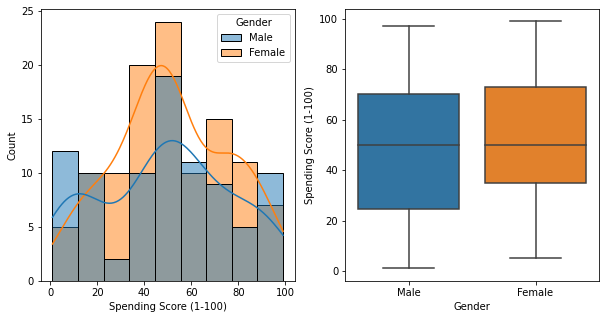

In [13]:
# Higher spending score for females than males 
print (df.groupby('Gender')['Spending Score (1-100)'].mean())
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.histplot(x='Spending Score (1-100)',data=df, hue='Gender', kde=True, ax=axes[0])
sns.boxplot(y='Spending Score (1-100)', x='Gender', data=df, ax=axes[1])

In [14]:
corr = df.corr()
corr

,Age,Annual Income (k$),Spending Score (1-100)
Age,1.000000,-0.012398,-0.327227
Annual Income (k$),-0.012398,1.000000,0.009903
Spending Score (1-100),-0.327227,0.009903,1.000000


<AxesSubplot:>

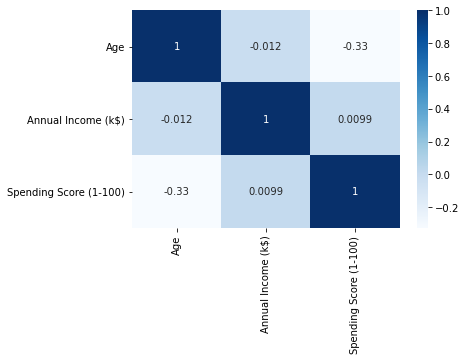

In [15]:
# negative relationship between age and income & spending score
# postive relationship between income and spending score
sns.heatmap(corr, annot=True, cmap='Blues')

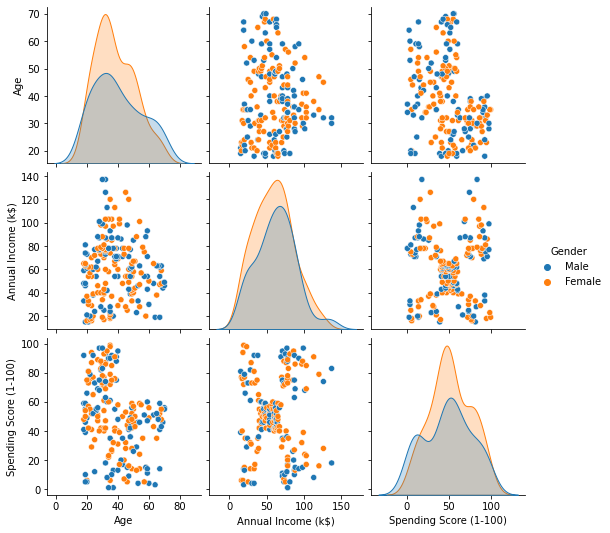

In [16]:
sns.pairplot(data=df, hue='Gender')

<AxesSubplot:xlabel='Annual Income (k$)', ylabel='Spending Score (1-100)'>

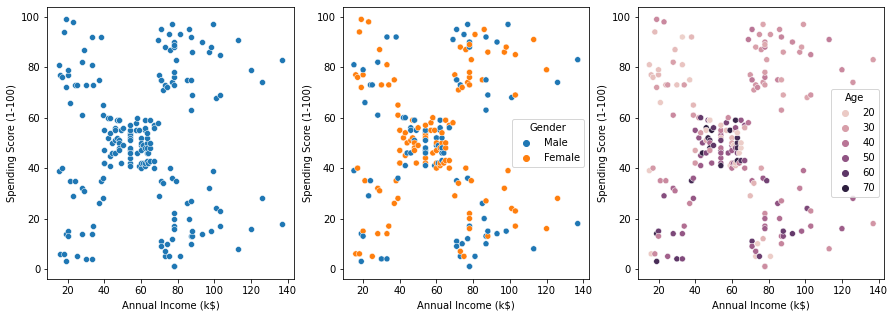

In [17]:
# the data seems to be devided into 5 cluster based on annual income and spending score
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
sns.scatterplot(x='Annual Income (k$)',y='Spending Score (1-100)',data=df, ax=axes[0])
sns.scatterplot(x='Annual Income (k$)',y='Spending Score (1-100)',hue='Gender',data=df, ax=axes[1])
sns.scatterplot(x='Annual Income (k$)',y='Spending Score (1-100)',hue='Age',data=df, ax=axes[2])

<AxesSubplot:xlabel='Age', ylabel='Spending Score (1-100)'>

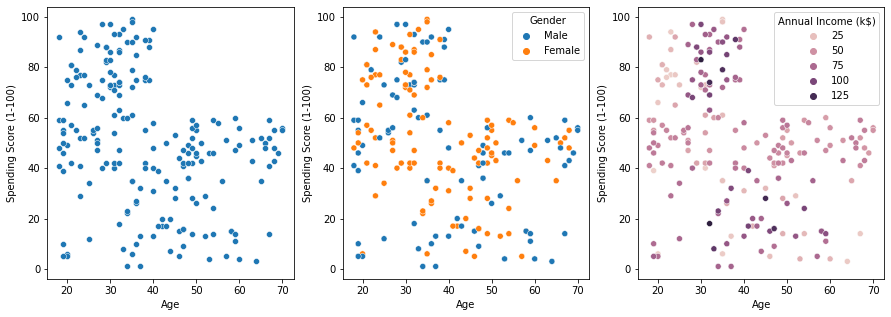

In [18]:
# there is no clear clustering between age and spending score
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
sns.scatterplot(x='Age',y='Spending Score (1-100)',data=df, ax=axes[0])
sns.scatterplot(x='Age',y='Spending Score (1-100)',hue='Gender',data=df, ax=axes[1])
sns.scatterplot(x='Age',y='Spending Score (1-100)',hue='Annual Income (k$)',data=df, ax=axes[2])

<AxesSubplot:xlabel='Age', ylabel='Annual Income (k$)'>

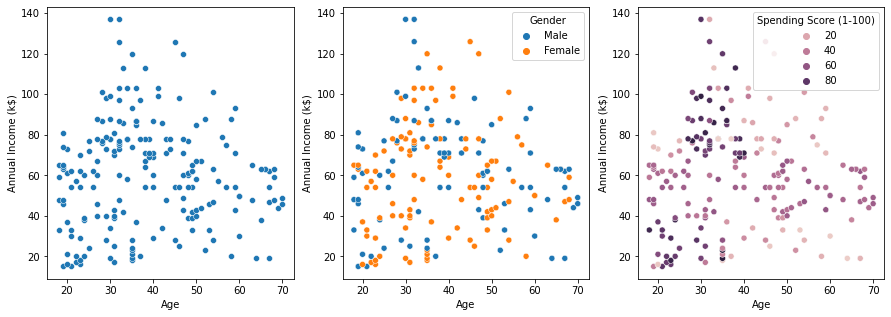

In [19]:
# there is no clear clustering between age and annual income
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
sns.scatterplot(x='Age',y='Annual Income (k$)',data=df, ax=axes[0])
sns.scatterplot(x='Age',y='Annual Income (k$)',hue='Gender',data=df, ax=axes[1])
sns.scatterplot(x='Age',y='Annual Income (k$)',hue='Spending Score (1-100)',data=df, ax=axes[2])

### 2. Data Normalization 

In [20]:
df['Gender'] = df['Gender'].map({'Male':1,'Female':0})
scaled_data = StandardScaler().fit_transform(df)

In [21]:
scaled_df = pd.DataFrame(scaled_data, columns = df.columns)
scaled_df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1.128152,-1.424569,-1.738999,-0.434801
1,1.128152,-1.281035,-1.738999,1.195704
2,-0.886405,-1.352802,-1.700830,-1.715913
3,-0.886405,-1.137502,-1.700830,1.040418
4,-0.886405,-0.563369,-1.662660,-0.395980


### 3. Hierarchical clustering

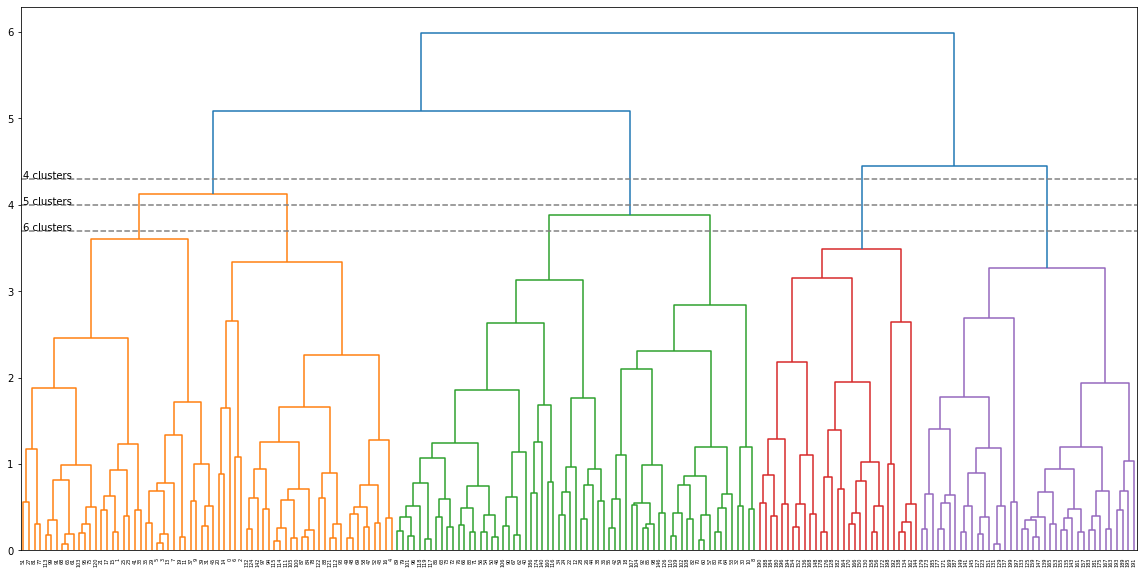

In [22]:
l = linkage(scaled_df, method='complete')

plt.figure(figsize=(20,10))
dendrogram(l,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.axhline(4.3, color='gray', linestyle='--')
plt.text(s='4 clusters', x=3.5, y=4.3)
plt.axhline(4, color='gray', linestyle='--')
plt.text(s='5 clusters', x=3.5, y=4)
plt.axhline(3.7, color='gray', linestyle='--')
plt.text(s='6 clusters', x=3.5, y=3.7)
plt.show()

Based on the dendrogram, the data can be divided between 4, 5 or 6 clusters but we need to understand the difference. Hene, we will evaluate the 3 scenarios and compare the results.

<AxesSubplot:xlabel='Age', ylabel='Spending Score (1-100)'>

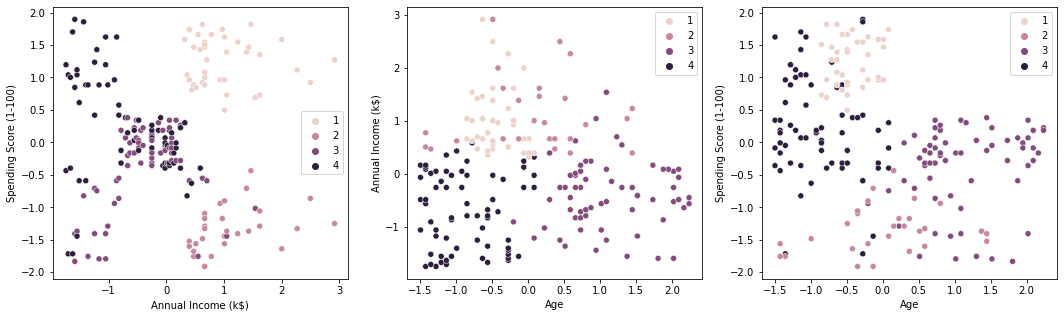

In [23]:
#assuming 4 clusters
cluster = fcluster(l,4, criterion='maxclust')
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
sns.scatterplot(x='Annual Income (k$)',y='Spending Score (1-100)',hue=cluster,data=scaled_df, ax=axes[0])
sns.scatterplot(x='Age',y='Annual Income (k$)',hue=cluster, data=scaled_df, ax=axes[1])
sns.scatterplot(y='Spending Score (1-100)',x='Age',hue=cluster, data=scaled_df, ax=axes[2])

1st & 2nd charts show clear clustering between annual income & income score and between Age and annual score. 3rd chart shows some overlaps between Age & spending score 

In [24]:
# Cluster definition 
df1 = df.copy()
df1['cluster'] = cluster
df1 = df1.groupby('cluster')[['cluster','Gender','Age','Spending Score (1-100)','Annual Income (k$)']].agg({'cluster':'count','Gender':'mean','Age':'mean','Spending Score (1-100)':'mean','Annual Income (k$)':'mean'}).sort_values(['Age'])
df1['pct'] = df1.iloc[:,0] / df1.iloc[:,0].sum() * 100
df1

,cluster,Gender,Age,Spending Score (1-100),Annual Income (k$),pct
cluster,,,,,,
4,67,0.373134,26.776119,56.522388,42.537313,33.5
1,39,0.461538,32.692308,82.128205,86.538462,19.5
2,29,0.620690,39.620690,15.758621,89.551724,14.5
3,65,0.415385,54.646154,39.892308,50.615385,32.5


<AxesSubplot:xlabel='Age', ylabel='Spending Score (1-100)'>

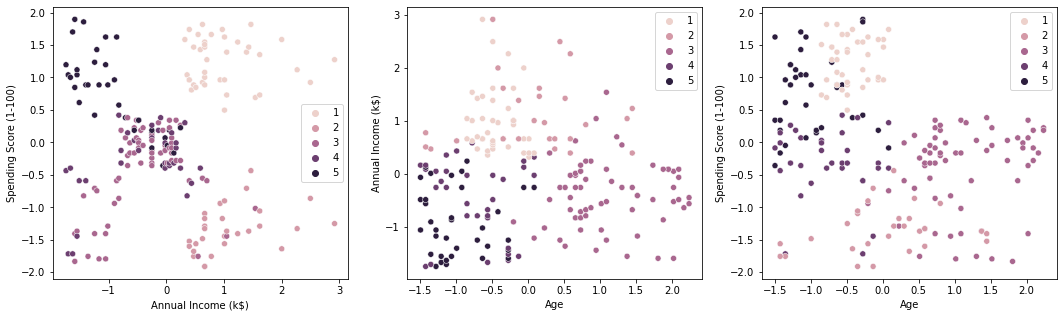

In [25]:
#assuming 5 clusters
cluster = fcluster(l,5, criterion='maxclust')
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
sns.scatterplot(x='Annual Income (k$)',y='Spending Score (1-100)',hue=cluster,data=scaled_df, ax=axes[0])
sns.scatterplot(x='Age',y='Annual Income (k$)',hue=cluster, data=scaled_df, ax=axes[1])
sns.scatterplot(y='Spending Score (1-100)',x='Age',hue=cluster, data=scaled_df, ax=axes[2])

We can see clear grouping between spending score & annual income and age and annual income in the 1st & 2nd charts. 3rd chart between Age & spending score still show some overlap but it's more clear here than in the previous scenario

In [26]:
# Cluster definition 
df2 = df.copy()
df2['cluster'] = cluster
df2 = df2.groupby('cluster')[['cluster','Gender','Age','Spending Score (1-100)','Annual Income (k$)']].agg({'cluster':'count','Gender':'mean','Age':'mean','Spending Score (1-100)':'mean','Annual Income (k$)':'mean'}).sort_values(['Age'])
df2['pct'] = df2.iloc[:,0] / df2.iloc[:,0].sum() * 100
df2

,cluster,Gender,Age,Spending Score (1-100),Annual Income (k$),pct
cluster,,,,,,
5,35,0.628571,25.228571,69.571429,36.714286,17.5
4,32,0.093750,28.468750,42.250000,48.906250,16.0
1,39,0.461538,32.692308,82.128205,86.538462,19.5
2,29,0.620690,39.620690,15.758621,89.551724,14.5
3,65,0.415385,54.646154,39.892308,50.615385,32.5


<AxesSubplot:xlabel='Age', ylabel='Spending Score (1-100)'>

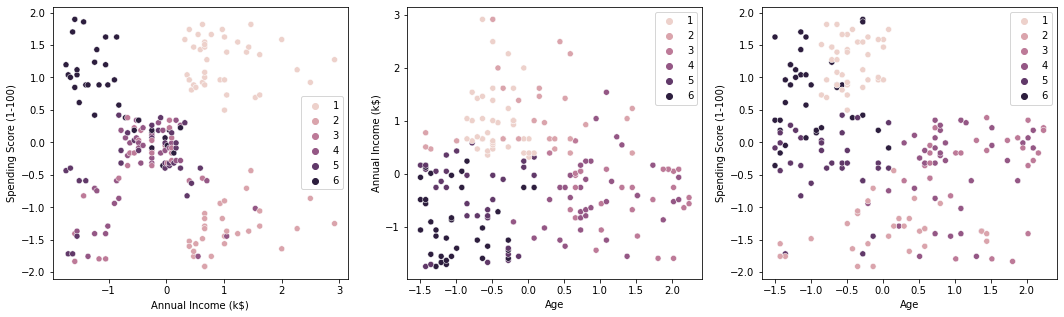

In [27]:
#assuming 6 clusters
cluster = fcluster(l,6, criterion='maxclust')
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
sns.scatterplot(x='Annual Income (k$)',y='Spending Score (1-100)',hue=cluster,data=scaled_df, ax=axes[0])
sns.scatterplot(x='Age',y='Annual Income (k$)',hue=cluster, data=scaled_df, ax=axes[1])
sns.scatterplot(y='Spending Score (1-100)',x='Age',hue=cluster, data=scaled_df, ax=axes[2])

the clustring in the 3 charts looks more clear than in the previous scnarios

In [28]:
# Cluster definition 
df3 = df.copy()
df3['cluster'] = cluster
df3 = df3.groupby('cluster')[['cluster','Gender','Age','Spending Score (1-100)','Annual Income (k$)']].agg({'cluster':'count','Gender':'mean','Age':'mean','Spending Score (1-100)':'mean','Annual Income (k$)':'mean'}).sort_values(['Age'])
df3['pct'] = df3.iloc[:,0] / df3.iloc[:,0].sum() * 100
df3

,cluster,Gender,Age,Spending Score (1-100),Annual Income (k$),pct
cluster,,,,,,
6,35,0.628571,25.228571,69.571429,36.714286,17.5
5,32,0.093750,28.468750,42.250000,48.906250,16.0
1,39,0.461538,32.692308,82.128205,86.538462,19.5
2,29,0.620690,39.620690,15.758621,89.551724,14.5
4,38,0.000000,52.368421,39.394737,51.236842,19.0
3,27,1.000000,57.851852,40.592593,49.740741,13.5


Now let's comapre the results between the 4, 5 & 6 clusters:
- 1 & 2 clusters are identical in all options :
 - 1st Cluster of customers in early 30s with high income and high spending score
 - 2nd Cluster of customers in late 30s with high income and low spending score
- Cluster 3 in 1st and 2nd scenario (representing 33.5%) is divided into 2 clusters in the 3rd scenario
 - 1st & 2nd Scenario : 32% are young customers in their 50s with average annual income and below average spending 
 - 3nd Scenario : 
   - 13% are MALE customers in their 50s with average income and below average spending score
   - 19% are FEMALE customers in their 50s with average income and below average spending score
- Cluster 4 in the 1st scenario (representing 32.5%) is divided into 2 clusters in the 2nd and 3rd scenario 
 - 1st Scenario : 33% are young customers in their 20s with below average annual income and relatively average spending 
 - 2nd & 3rd Scenario : 
   - 17% are young customers in their mid 20s with low income and high spending score
   - 16% are young customers in their late 20s with below average annual income and average spending score
   
Now that we understand the difference between the 3 scenarios, the question is:
- does it make sense to create 2 groups for specifically MALES & FEMALES in their 50s since both have relatively the same average annual income and the same average spending score?
- does it make sense to create 2 groups for customers in their 20s, younger group (mid 20s) with higher spending score and lower annual income while the other group (late 20s) is with lower spending score and higher annual income?

I would say yes for couple of reason:
- Males and females in their 50s represent 33% of the customers (19% & 13% after dividing them) with different interests and shopping behavior although both have the same annual income and similar spending score. 
- Customers in their 20s represent 32.5% of the customers (17% & 16%) where we see the younger ones having lower income and higher spending score and older ones with higher income and lower spending score. This can be explained the first group is still trying to establish themselves while the other group is progressing in their career. Again the interests are different and the shopping behavior is different.   


Therefore, using hierarchical clustering, we divided the mall customers into 6 groups:
- customers in early 30s with high income and high spending score
- customers in late 30s with high income and low spending score
- male customers in their 50s with average income and below average spending score
- female customers in their 50s with average income and below average spending score
- young customers in their mid 20s with low income and high spending score
- young customers in their late 20s with below average annual income and average spending score

### 3. K-MEANS Clustering

In [29]:
inertias = []
silhouette_coefficients = []
cluster_num = range(1, 11)
for i in cluster_num:
    kmeans = KMeans(n_clusters = i, random_state=0)
    kmeans.fit(scaled_df)
    inertias.append(kmeans.inertia_)
    if i>1:
        score = silhouette_score(scaled_df,kmeans.labels_)
        silhouette_coefficients.append(score)

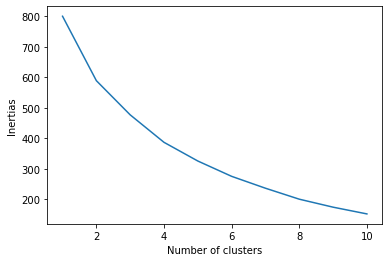

In [30]:
# The Elbow Method - there in no clear cut to decide on the number of clusters
plt.plot(cluster_num, inertias)
plt.xlabel('Number of clusters')
plt.ylabel('Inertias')
plt.show()

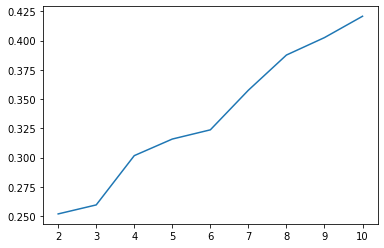

In [31]:
# silhouette coefficients - again no clear breaking point to decide on the number of clusters
plt.plot(range(2, 11), silhouette_coefficients)

In [32]:
# trying to re-do the analysis after excluding Gender
X = scaled_df.iloc[:,1:]
inertias = []
silhouette_coefficients = []
cluster_num = range(1, 11)
for i in cluster_num:
    kmeans = KMeans(n_clusters = i, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    if i>1:
        score = silhouette_score(X,kmeans.labels_)
        silhouette_coefficients.append(score)

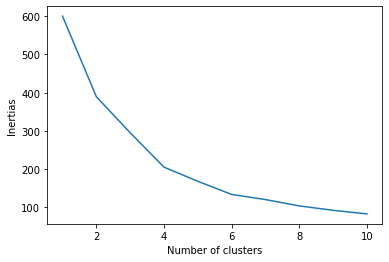

In [33]:
# The Elbow Method - it seems like 4 or 6 clusters is ideal number for the analysis
plt.plot(cluster_num, inertias)
plt.xlabel('Number of clusters')
plt.ylabel('Inertias')
plt.show()

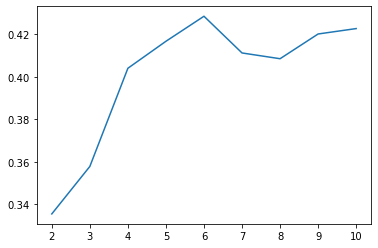

In [34]:
# silhouette coefficients - based on the chart below, ideally we should have 6 clusters
plt.plot(range(2, 11), silhouette_coefficients)

In [35]:
# based on the above, we will evaluate assuming 6 clusters
kmeans = KMeans(n_clusters = 6)
kmeans.fit_predict(X)
cluster = kmeans.predict(X)

<AxesSubplot:xlabel='Age', ylabel='Spending Score (1-100)'>

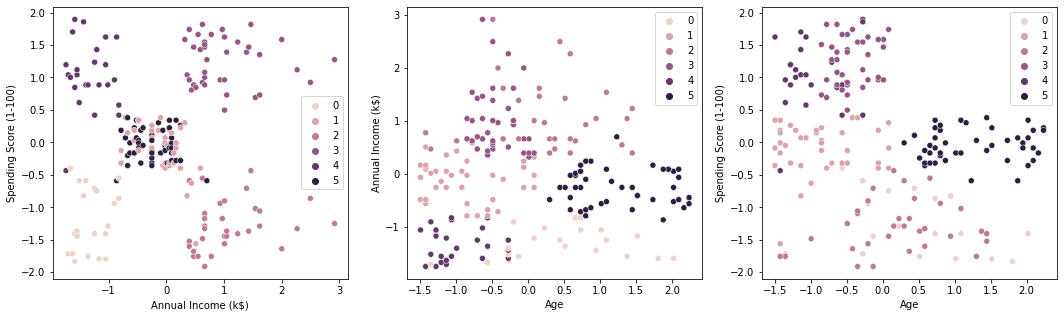

In [36]:
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
sns.scatterplot(x='Annual Income (k$)',y='Spending Score (1-100)',hue=cluster,data=X, ax=axes[0])
sns.scatterplot(x='Age',y='Annual Income (k$)',hue=cluster, data=X, ax=axes[1])
sns.scatterplot(y='Spending Score (1-100)',x='Age',hue=cluster, data=X, ax=axes[2])
#plt.plot(kmeans.cluster_centers_)

The 3 charts show almost clear grouping between spending score & annual income, age & annual income and between Age & spending score - actually the clusters here are more clear than in hierarchal clustering

In [37]:
# Cluster definition 
df4 = df.copy()
df4['cluster'] = cluster
df4 = df4.groupby('cluster')[['cluster','Gender','Age','Spending Score (1-100)','Annual Income (k$)']].agg({'cluster':'count','Gender':'mean','Age':'mean','Spending Score (1-100)':'mean','Annual Income (k$)':'mean'}).sort_values(['Age'])
df4['pct'] = df4.iloc[:,0] / df4.iloc[:,0].sum() * 100
df4

,cluster,Gender,Age,Spending Score (1-100),Annual Income (k$),pct
cluster,,,,,,
4,24,0.416667,25.250000,76.916667,25.833333,12.0
1,38,0.368421,26.684211,47.789474,57.578947,19.0
3,39,0.461538,32.692308,82.128205,86.538462,19.5
2,33,0.575758,41.939394,16.969697,88.939394,16.5
0,21,0.380952,45.523810,19.380952,26.285714,10.5
5,45,0.422222,56.333333,49.066667,54.266667,22.5


Using hierarchical clustering, we divided the mall customers into 6 groups:
- Young customers in their mid 20s with low annual income (averaging 25k) and high spending score (41% females)
- Young customers in their mid 20s with average annual income (averaging 47k) and average spending score (36% females)
- Customers in their early 30s with high annual income (averaging 86k) and high spending score (46% females)
- Customers in their early 40s with high annual income (averaging 89k) and low spending score (57% females)
- Customers in their mid 40s with low annual income (averaging 26k) and low spending score (38% females)
- Customers in their mid 50s with medium annual income (averaging 49k) and medium spending score (42% females)

### 4. DBSCAN Clustering

In [38]:
# decide on the number of clusters
silhouette_coefficients = []
for eps in np.linspace(0.1,1,10):
    for min_samples in  np.linspace(5,25,5,dtype=int):
        dbscan = DBSCAN(eps=eps,min_samples=min_samples)
        dbscan.fit_predict(scaled_df)
        labels = dbscan.labels_
        if (len(np.unique(labels))>3):
            # Number of clusters in labels, ignoring noise if present - only show if number of clusters >=2
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise_ = list(labels).count(-1)
            print (f"clusters: {n_clusters_}, noise: {n_noise_} (eps : {eps:1.2f}, min_samples:{min_samples})")

clusters: 4, noise: 165 (eps : 0.40, min_samples:5)
clusters: 9, noise: 105 (eps : 0.50, min_samples:5)
clusters: 9, noise: 62 (eps : 0.60, min_samples:5)
clusters: 3, noise: 147 (eps : 0.60, min_samples:10)
clusters: 7, noise: 37 (eps : 0.70, min_samples:5)
clusters: 5, noise: 106 (eps : 0.70, min_samples:10)
clusters: 5, noise: 19 (eps : 0.80, min_samples:5)
clusters: 4, noise: 68 (eps : 0.80, min_samples:10)
clusters: 3, noise: 137 (eps : 0.80, min_samples:15)
clusters: 5, noise: 46 (eps : 0.90, min_samples:10)


In [39]:
# minimum noise with 5 clusters at eps =0.8 & min_samples=5
dbscan = DBSCAN(eps=0.8,min_samples=5)
dbscan.fit_predict(scaled_df)
labels = dbscan.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print (f"clusters: {n_clusters_}, noise: {n_noise_}")

clusters: 5, noise: 19


<AxesSubplot:xlabel='Age', ylabel='Spending Score (1-100)'>

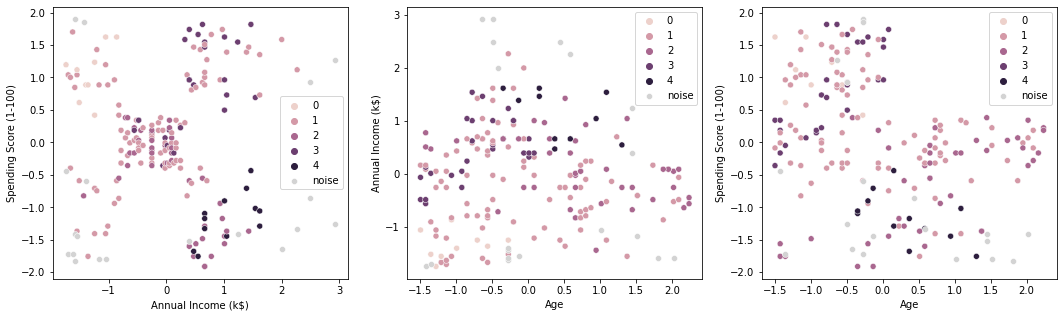

In [40]:
dbscan_df = scaled_df.copy()
dbscan_df['label'] = labels

fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
sns.scatterplot(x='Annual Income (k$)',y='Spending Score (1-100)',hue='label',data=dbscan_df[dbscan_df['label']!=-1], ax=axes[0])
sns.scatterplot(x='Age',y='Annual Income (k$)',hue='label', data=dbscan_df[dbscan_df['label']!=-1], ax=axes[1])
sns.scatterplot(y='Spending Score (1-100)',x='Age',hue='label', data=dbscan_df[dbscan_df['label']!=-1], ax=axes[2])

sns.scatterplot(x='Annual Income (k$)',y='Spending Score (1-100)',data=dbscan_df[dbscan_df['label']==-1], color='lightgray', ax=axes[0],label='noise')
sns.scatterplot(x='Age',y='Annual Income (k$)', data=dbscan_df[dbscan_df['label']==-1],color='lightgray', ax=axes[1],label='noise')
sns.scatterplot(y='Spending Score (1-100)',x='Age', data=dbscan_df[dbscan_df['label']==-1],color='lightgray', ax=axes[2], label='noise')


In [41]:
# Cluster definition 
df5 = df.copy()
df5['cluster'] = labels
df5 = df5.groupby('cluster')[['cluster','Gender','Age','Spending Score (1-100)','Annual Income (k$)']].agg({'cluster':'count','Gender':'mean','Age':'mean','Spending Score (1-100)':'mean','Annual Income (k$)':'mean'}).sort_values(['Age'])
df5['pct'] = df5.iloc[:,0] / df5.iloc[:,0].sum() * 100
df5

,cluster,Gender,Age,Spending Score (1-100),Annual Income (k$),pct
cluster,,,,,,
0,9,1.000000,25.000000,77.666667,25.777778,4.5
3,26,1.000000,28.961538,71.423077,72.076923,13.0
1,94,0.000000,37.542553,56.095745,55.893617,47.0
-1,19,0.684211,41.947368,30.157895,61.000000,9.5
4,12,0.000000,43.416667,20.416667,88.333333,6.0
2,40,1.000000,48.625000,34.825000,63.325000,20.0


DBSCAN Clustring is clearly dividing males and females:
- Males in their mid 20s with low annual income and high spending score
- Males in their late 20s with high annual income and high spending score
- Females in their late 30s with medium annual income and medium spending score 
- Females in their mid 40s with high annual income and low spending score 
- Males in their late 40s with relatively high annual income and relatively low spending score 

### 5. Conclusion 

- The results of hierarchical and KMeans clustering were not far off although we included Gender in the Hierarchical model and excluded it from KMeans
- DBSCAN analysis clearly divided the clusters based on Gender and then factored the other features in the analysis